In [ ]:
import os
import sys
newPath = os.path.dirname(os.path.dirname(os.path.abspath("")))
if newPath not in sys.path:
    sys.path.append(newPath)

from BI import bi
from jax import jit
from functools import partial
import time as tm
# Bi modules
bi = bi(platform='cpu')
print(bi.dist.normal(0,1, sample = True, shape=(1,), seed = 1))
bi.net.mat_to_edgl(jnp.array([[1, 2, 3, 4],
                              [5, 6, 7, 8],
                              [9, 10, 11, 12],
                              [13, 14, 15, 16]]))
print(bi.gaussian_process)
print(bi.random_centered)

# Networks Models

## Rethinking

In [7]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('../data/kl_dyads')
d2 = pd.read_csv('../data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)

m.data_on_model = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    # gr matrix of varying effects
    Rho_gr = dist.lkj(2, 4, name = "Rho_gr")
    sigma_gr = dist.exponential( 1, shape = [2], name = "sigma_gr")
    cov = jnp.outer(sigma_gr, sigma_gr) * Rho_gr
    gr = dist.multivariatenormal(0, cov, name = "gr", shape = [N_households])

    # dyad effects
    z = dist.normal(0, 1, name = 'z', shape = [2, N])
    L_Rho_d = dist.lkjcholesky(2, 8, name = "L_Rho_d")
    sigma_d = dist.exponential(1, name = "sigma_d", shape = [1])
    d = numpyro.deterministic(
        "d", ((jnp.repeat(sigma_d, 2)[..., None] * L_Rho_d) @ z).T
    )

    a = dist.normal(0, 1, name = 'a')
    lambdaAB = jnp.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[:, 0])
    lambdaBA = jnp.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[:, 1])
    lk("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    lk("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------
m.run(model) 
res = az.from_numpyro(m.sampler)
res

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:03<00:00, 260.89it/s, 63 steps of size 9.02e-02. acc. prob=0.89]


BI took: 5.9322 seconds


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Trying bi functions

In [42]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('../data/kl_dyads')
d2 = pd.read_csv('../data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)
m.data_on_model = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    ## SR ---------------------------------------
    d, sr_raw, sr_sigma, sr_L = bi.net.nodes_random_effects(N_households, cholesky_density= 4)

    # dyad effects ---------------------------------------
    gr, dr_raw, dr_sigma, dr_L = bi.net.dyadic_random_effects(N, cholesky_density= 8 )

    a = dist.normal(0, 1, name = 'a')
    lambdaAB = jnp.exp(a + d[hidA, 0] + d[hidB, 1] + gr[:, 0])
    lambdaBA = jnp.exp(a + d[hidB, 0] + d[hidA, 1] + gr[:, 1])
    lk("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    lk("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------

m.run(model) 
res2 = az.from_numpyro(m.sampler)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:06<00:00, 156.74it/s, 255 steps of size 2.22e-02. acc. prob=0.93]


BI took: 6.6370 seconds


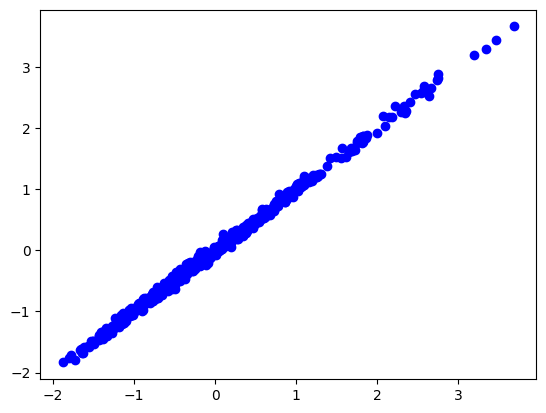

In [43]:
plt.plot(jnp.mean(jnp.array(res['posterior']['d']), axis = 1)[0,:,0],
         jnp.mean(jnp.array(res2['posterior']['dr_rf']), axis = 1)[0,:,0], marker='o', linestyle='None', color='b', label='Posteriors')

plt.plot(jnp.mean(jnp.array(res['posterior']['d']), axis = 1)[0,:,1],
         jnp.mean(jnp.array(res2['posterior']['dr_rf']), axis = 1)[0,:,1], marker='o', linestyle='None', color='b', label='Posteriors')

## STRAND

### Utilities functions

In [2]:
%load_ext rpy2.ipython

In [115]:
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import numpy2ri


#strand_posteriors = ro.r['strand_post']
def strand_to_dict(strand_posteriors):
    names = list(strand_posteriors.names)

    strand_p = {}
    with localconverter(ro.default_converter + numpy2ri.converter):
        for i, name in enumerate(names):
            if len(strand_posteriors[i]) > 1: 
                for a in range(len(strand_posteriors[i])):
                    strand_p[name + str(a)] = np.array(strand_posteriors[i][a])
            else:
                strand_p[name] = np.array(strand_posteriors[i])
    return strand_p

def compare_results(BI_posteriors, strand_posteriors):
    mapping = {
        'focal_target_sd': 'sr_sigma',  # same
        'focal_target_L': 'sr_L',
        'target_coeffs': 'receiver_effects',
        'focal_coeffs': 'sender_effects',
        'dyadic_L': 'dr_L',
        'error_sd': 'sr_sigma',
        'dyadic_random_effects': 'dr_rf',
        'dyadic_sd': 'dr_sigma',
    }
    # --- Dynamic block parameters mapping ---
    block_keys = sorted([k for k in strand_p.keys() if k.startswith('block_parameters')])

    if len(block_keys) == 1:
        # Only one block → use b_intercept
        mapping['b_intecept'] = block_keys[0]
    else:
        # Multiple blocks → b_0, b_1, ...
        for i, blk in enumerate(block_keys):
            m_key = f"b_{i}"   # e.g. b_0, b_1
            mapping[m_key] = blk

    import numpy as np

    summaries = []

    for s_key, m_key  in mapping.items():
        # Get arrays
        arr_m = BI_posteriors[m_key]
        arr_s = strand_posteriors[s_key]

        # Handle dr_rf special case
        if m_key == 'dyadic_random_effects':
            arr_m = m.net.edlg_to_mat(arr_m)

        # Flatten to 1D (e.g. if multidimensional)
        arr_m = arr_m.reshape(arr_m.shape[0], -1)
        arr_s = arr_s.reshape(arr_s.shape[0], -1)

        # Compute means and sds for each parameter
        mean_m = arr_m.mean(axis=0)
        sd_m = arr_m.std(axis=0)

        mean_s = arr_s.mean(axis=0)
        sd_s = arr_s.std(axis=0)

        # Average across parameters for visual simplicity
        summaries.append({
            'param': m_key,
            'mean_m': mean_m.mean(),
            'sd_m': sd_m.mean(),
            'mean_s': mean_s.mean(),
            'sd_s': sd_s.mean()
        })
    import matplotlib.pyplot as plt

    params = [d['param'] for d in summaries]
    mean_m = np.array([d['mean_m'] for d in summaries])
    sd_m = np.array([d['sd_m'] for d in summaries])
    mean_s = np.array([d['mean_s'] for d in summaries])
    sd_s = np.array([d['sd_s'] for d in summaries])

    y = np.arange(len(params))

    plt.figure(figsize=(8, 6))
    plt.errorbar(mean_m, y + 0.1, xerr=sd_m, fmt='o', label='m.posteriors', capsize=3)
    plt.errorbar(mean_s, y - 0.1, xerr=sd_s, fmt='o', label='strand_p', capsize=3)
    plt.yticks(y, params)
    plt.axvline(0, color='gray', linestyle='--')
    plt.xlabel('Posterior mean ± 1 SD')
    plt.legend()
    plt.title('Forest Plot Comparison: strand_p vs m.posteriors')
    plt.tight_layout()
    plt.show()


### Sender receiver model

#### STRAND simulation

In [12]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R 
# Clear working space
rm(list = ls())
set.seed(10)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)

# Make data
N_id = 50

# Covariates
Mass = rbern(N_id, 0.4)

B_1 = matrix(-4,nrow=1,ncol=1)
B=list(B_1)
groups_1 = rep("Any",N_id) 
groups = data.frame(Intercept=as.numeric(factor(groups_1)))
groups_f = data.frame(Intercept=factor(groups_1))
#################################################### Simulate SBM + SRM network
sr_effects_1 = c(-1.9, 1.3)
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         B = B, 
                         V=1,
                         groups=groups,                  
                         sr_mu = c(0,0),  
                         sr_sigma = c(2.2, 1.7) , 
                         sr_rho = 0.55,
                         outcome_mode="bernoulli", 
                         link_mode="logit",                 
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = NULL,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = NULL
                         )        

################################################### Organize for model fitting
colnames(G$network)=rownames(G$network)=1:N_id


model_dat = make_strand_data(outcome=list("Assoc"=G$network),  
                              individual_covariates=data.frame(Mass=Mass), 
                              outcome_mode = "bernoulli", 
                              link_mode="logit")

# Model the data with STRAND
fit =  fit_social_relations_model(data=model_dat,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ 1,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1,
                                                          refresh = 500,iter_warmup = 500,
                                                          iter_sampling = 500,
                                                          max_treedepth = NULL,
                                                          adapt_delta = .9)
                            )

## Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'STRAND sim sr only.Rdata')

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 130.9 seconds.
$`Focal effects: Out-degree`
     Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.627"  "1.924"   "3.512"  
[2,] "focal effects coeffs (out-degree), Mass" "-2.206" "-3.768"  "-0.915" 
     Mean     SD      P      
[1,] "2.721"  "0.564" "0"    
[2,] "-2.265" "0.914" "0.002"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.857" "1.288"   "2.438"  
[2,] "target effects coeffs (in-degree), Mass" "1.582" "0.48"    "2.49"   
     Mean    SD      P      
[1,] "1.898" "0.383" "0"    
[2,] "1.592" "0.633" "0.006"

$`Dyadic effects`
     Variable            Media

Loading required package: cmdstanr
This is cmdstanr version 0.9.0
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/sosa/.cmdstan/cmdstan-2.37.0
- CmdStan version: 2.37.0
Loading required package: posterior
This is posterior version 1.6.1

Attaching package: ‘posterior’

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

Loading required package: parallel
rethinking (Version 2.42)

Attaching package: ‘rethinking’

The following objects are masked from ‘package:STRAND’:

    HPDI, inv_logit, logit, rbern, rmvnorm, rmvnorm2, standardize

The following object is masked from ‘package:stats’:

    rstudent

Model executable is up to date!
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/RtmpTKwxgX/

#### Send simulation to python

In [1]:
%load_ext rpy2.ipython

In [13]:
%%R
library(STRAND)
load('STRAND sim sr only.Rdata')
res = summarize_strand_results(fit)
strand_posteriors = res$samples$srm_model_samples

$`Focal effects: Out-degree`
     Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.627"  "1.924"   "3.512"  
[2,]     Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.627"  "1.924"   "3.512"  
[2,] "focal effects coeffs (out-degree), Mass" "-2.206" "-3.768"  "-0.915" 
     Mean     SD      P      
[1,] "2.721"  "0.564" "0"    
[2,] "-2.265" "0.914" "0.002"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.857" "1.288"   "2.438"  
[2,] "target effects coeffs (in-degree), Mass" "1.582" "0.48"    "2.49"   
     Mean    SD      P      
[1,] "1.898" "0.383" "0"    
[2,] "1.592" "0.633" "0.006"

$`Dyadic effects`
     Variable            Median HPDI:0.05 HPDI:0.95 Mean    SD      P  
[1,] "dyadic effects sd" "1.67" "0.702"   "2.553"   "1.723" "0.5

#### Model

In [3]:
from BI import bi
import jax.numpy as jnp
from BI.Diagnostic.jax_summary import *
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
data['individual_predictors'] = data['individual_predictors'].T

jax.local_device_count 16


In [5]:
def logit(x):
    return jnp.log(x / (1 - x))

def model( result_outcomes,focal_individual_predictors, target_individual_predictors):
    N_id = focal_individual_predictors.shape[0]

    ## Block ---------------------------------------
    B=m.net.block_model(jnp.full(N_id,0),1,N_id, name='intecept')

    #SR ---------------------------------------
    sr =  m.net.sender_receiver(
        focal_individual_predictors,
        target_individual_predictors,
        s_sd=2.5, r_sd=2.5
        )

    ### Dyadic--------------------------------------  
    #dr, dr_raw, dr_sigma, dr_L = bi.net.dyadic_random_effects(idx.shape[0], cholesky_density = 2)# shape = n dyads
    dr = m.net.dyadic_effect(shape = sr.shape[0], d_sd=2.5) # Diadic effect intercept only 
    ## SR ---------------------------------------                                                      
    m.dist.bernoulli(logits = B + sr + dr, obs=result_outcomes)

    ## NBDA -----------------------------     

m.data_on_model = dict(
    result_outcomes = m.net.mat_to_edgl(data['outcomes']), 
    focal_individual_predictors = data['individual_predictors'],
    target_individual_predictors = data['individual_predictors']
)

m.fit(model) 
#summary = m.summary()
summary=jax_summary(m.posteriors)
summary[summary.index.str.contains('b_intecept|receiver_effects|sender_effects')]
# focal_effects = -1.9,
# target_effects =  1.3
# block =  -4

sample: 100%|██████████| 1000/1000 [00:18<00:00, 54.76it/s, 63 steps of size 8.05e-02. acc. prob=0.91]


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
var,,,,,,,,,
b_intecept[0],-4.241,0.996,-5.854,-2.847,0.045,0.032,500.0,500.0,NaN
receiver_effects,1.483,0.619,0.597,2.455,0.028,0.020,500.0,500.0,NaN
sender_effects,-2.047,0.786,-3.255,-0.748,0.035,0.025,500.0,500.0,NaN


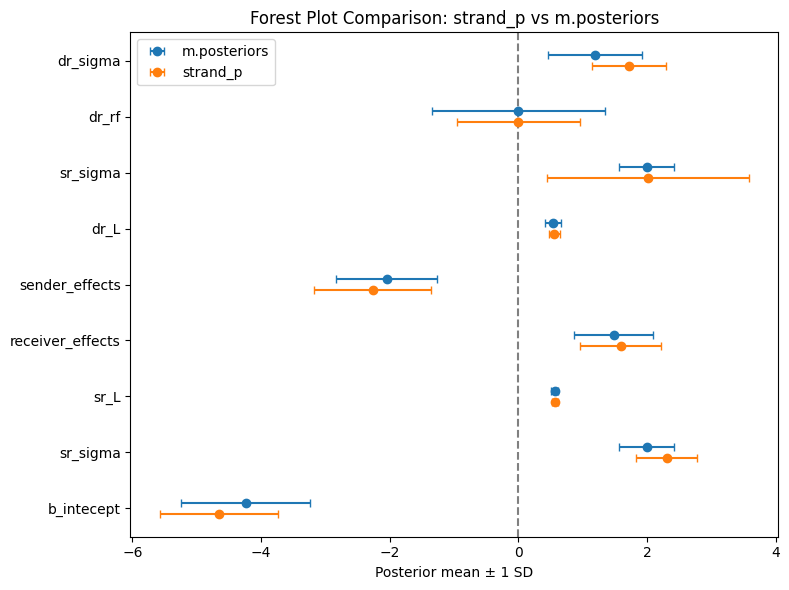

In [20]:
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import numpy2ri


strand_posteriors = ro.r['strand_posteriors']
strand_posteriors = strand_to_dict(strand_posteriors)
dr_rf_converted = vmap(lambda x: m.net.edgl_to_mat(x, 50), in_axes=0, out_axes=0)(m.posteriors['dr_rf'])

compare_results(m.posteriors, strand_posteriors)

### Sender receiver & dyadic effects model

#### Method accuracy demonstration.

In [100]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [101]:
%%R 
library(STRAND)
dr_raw = matrix(0, ncol = 3, nrow = 3)
dr_raw[1,] = c(0, 0.6, 0.66)
dr_raw[2,] = c(0.1, 0, 0.9)
dr_raw[3,] = c(-0.5, 0.24, 0)
tl = lower.tri(dr_raw, diag = FALSE)
tu = upper.tri(dr_raw, diag = FALSE)
dr2 = cbind(dr_raw[tl], dr_raw[tu])
d.sigma = c(0.2,0.2)

Rho = matrix(1, ncol = 2, nrow = 2)
rho = 0.73
Rho[1,2] = rho
Rho[2,1] = rho
L = chol(Rho)

R = NULL
for( a in 1:nrow(dr2)){
  R[[a]] = (L %*% dr2[a,]) * d.sigma
}
R


[[1]]
           [,1]
[1,] 0.10760000
[2,] 0.08201366
           [,1]
[1,] 0.10760000
[2,] 0.08201366

[[2]]
            [,1]
[1,] -0.00364000
[2,]  0.09021502

[[3]]
          [,1]
[1,] 0.1794000
[2,] 0.1230205



In [102]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
L = jnp.array(ro.globalenv['L']).reshape(2,2)
dr2 = jnp.array(ro.globalenv['dr2']).reshape(3,2).T
d_sigma = jnp.array(ro.globalenv['d.sigma'])
(L @ dr2).T * d_sigma

Array([[ 0.1076    ,  0.08201366],
       [-0.00364   ,  0.09021502],
       [ 0.1794    ,  0.12302049]], dtype=float64)

Code used in function is:

In [103]:
dr_raw =  m.dist.normal(0, 1, shape=(2, 3), name = 'dr_raw', sample = True)
dr_sigma = m.dist.exponential(1, shape=(1,), name = 'dr_sigma', sample = True )
dr_L = m.dist.lkj_cholesky(2, 2, name = 'dr_L', sample = True)
rf = ((dr_L @ dr_raw).T * jnp.repeat(dr_sigma, 2))
rf

Array([[-0.11158096,  0.13835452],
       [-0.42539842,  0.21275884],
       [ 0.98444711, -0.58399327]], dtype=float64)

#### Simulated data

In [37]:
%%R 
# Clear working space
rm(list = ls())
set.seed(10)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)

# Make data
N_id = 50

# Covariates
Kinship = rlkjcorr( 1 , N_id , eta=1.5 )
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
dyadic_preds = array(NA,c(N_id,N_id,1))

dyadic_preds[,,1] = Kinship
#dyadic_preds[,,2] = Dominant
#dyadic_preds[,,3] = Kinship*Dominant

# Set effect sizes
sr_mu = c(0,0)  
sr_sigma = c(2.2, 1.7) 
sr_rho = 0.55
dr_mu = 0  
dr_sigma = 1.5
dr_rho= 0.6

B_1 = matrix(-4,nrow=1,ncol=1)
B=list(B_1)
groups_1 = rep("Any",N_id) 
groups = data.frame(Intercept=as.numeric(factor(groups_1)))
groups_f = data.frame(Intercept=factor(groups_1))

#################################################### Simulate SBM + SRM network
sr_effects_1 = c(1.9, 1.3)
dr_effects_1 = c(1.2)
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         B = B, 
                         V=1,
                         groups=groups,                  
                         sr_mu = sr_mu,  
                         sr_sigma = sr_sigma, 
                         sr_rho = sr_rho,
                         dr_mu = dr_mu,  
                         dr_sigma = dr_sigma, 
                         dr_rho = dr_rho,
                         outcome_mode="bernoulli", 
                         link_mode="logit",                 
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = dyadic_preds,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = dr_effects_1                         
                         )        
                         
################################################### Organize for model fitting
colnames(G$network)=rownames(G$network)=1:N_id
colnames(Kinship)=rownames(Kinship)=1:N_id
colnames(G$network)=rownames(G$network)=1:N_id
Kinship= matrix(Kinship,ncol=N_id, nrow= N_id)
Kinship= matrix(standardize(Kinship),ncol=N_id, nrow= N_id)
colnames(Kinship)=rownames(Kinship)=1:N_id

model_dat = make_strand_data(outcome=list("Assoc"=G$network),  
                              individual_covariates=data.frame(Mass=Mass), 
                              dyadic_covariates=list(Kinship=Kinship),
                              outcome_mode = "bernoulli", 
                              link_mode="logit")


# Model the data with STRAND
fit =  fit_social_relations_model(data=model_dat,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ Kinship,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1,
                                                          refresh = 500,iter_warmup = 500,
                                                          iter_sampling = 500,
                                                          max_treedepth = NULL,
                                                          adapt_delta = .9)
                            )

## Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'STRAND sim sr dyad.Rdata')

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 208.2 seconds.
$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.809" "1.897"   "4"      
[2,] "focal effects coeffs (out-degree), Mass" "2.468" "1.22"    "4.195"  
     Mean    SD      P      
[1,] "2.911" "0.716" "0"    
[2,] "2.54"  "0.923" "0.002"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "2.557" "1.642"   "3.674"  
[2,] "target effects coeffs (in-degree), Mass" "1.31"  "-0.087"  "2.51"   
     Mean    SD      P      
[1,] "2.633" "0.658" "0"    
[2,] "1.354" "0.813" "0.038"

$`Dyadic effects`
     Variable                       

Loading required package: cmdstanr
This is cmdstanr version 0.9.0
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/sosa/.cmdstan/cmdstan-2.37.0
- CmdStan version: 2.37.0
Loading required package: posterior
This is posterior version 1.6.1

Attaching package: ‘posterior’

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

Loading required package: parallel
rethinking (Version 2.42)

Attaching package: ‘rethinking’

The following objects are masked from ‘package:STRAND’:

    HPDI, inv_logit, logit, rbern, rmvnorm, rmvnorm2, standardize

The following object is masked from ‘package:stats’:

    rstudent

Model executable is up to date!
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/RtmpTKwxgX/

#### Send simulation to python

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr dyad.Rdata')
res = summarize_strand_results(fit)
strand_posteriors = res$samples$srm_model_samples

$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.809" "1.897"   "4"      
[2,] "focal effects coeffs (out-degree), Mass" "2.468" "1.22"    "4.195"  
     Mean    SD      P      
[1,] "2.911" "0.716" "0"    
[2,] "2.54"  "0.923" "0.002"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "2.557" "1.642"   "3.674"  
[2,] "target effects coeffs (in-degree), Mass" "1.31"  "-0.087"  "2.51"   
     Mean    SD      P      
[1,] "2.633" "0.658" "0"    
[2,] "1.354" "0.813" "0.038"

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyadic effects sd"              "2.636" "1.36"    "4.171"   "2.757"
[2,] "dyadic effects coeffs, Kinship" "0.4"   "0.119"   "0.736"   "0.423"
     SD      P      
[1,] "0.928" "0"    
[2,] "0.201" "0.008"

$`Other esti

STRAND: Social network analysis and simulation in R using Stan.
This version of STRAND is: our_dire_reveille.


#### Model

In [41]:
from BI import bi
import jax.numpy as jnp
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
kinship = data['dyadic_predictors'].reshape(data['N_id'][0],data['N_id'][0]).T
exposure = data['exposure'].reshape(data['N_id'][0],data['N_id'][0]).T

def model(result_outcomes, dyadic_predictors, focal_individual_predictors, target_individual_predictors):

    # Block ---------------------------------------
    B=m.net.block_model(jnp.full(50,0),1, 50, name = 'intecept')

    ## SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(
        focal_individual_predictors,target_individual_predictors,
        s_sd=2.5, r_sd=2.5, sr_sd = 2.5, sr_sigma_rate= 2.5)

    # Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(dyadic_predictors, d_sd=1, dr_sd=1)

    m.dist.bernoulli(logits=B + sr + dr, obs=result_outcomes) #Block intercept is fixed as e know it

m.data_on_model = dict(
    result_outcomes = m.net.mat_to_edgl(data['outcomes']), 
    dyadic_predictors = m.net.prepare_dyadic_effect(kinship), # Can be a jax array of multiple dimensions
    focal_individual_predictors = data['individual_predictors'].T,
    target_individual_predictors = data['individual_predictors'].T
)

m.fit(model, num_samples = 500, num_warmup = 500, num_chains = 1, thinning = 1, progress_bar = True)
summary=m.summary()
summary[summary.index.str.contains('dyad_effects|receiver_effects|sender_effects|b_intecept')]


jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:21<00:00, 46.80it/s, 63 steps of size 9.09e-02. acc. prob=0.91]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide

/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide



,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"b_intecept[0, 0]",-4.28,0.98,-5.83,-2.84,0.47,0.10,4.10,79.74,NaN
dyad_effects[0],0.31,0.14,0.10,0.53,0.03,0.00,21.85,458.35,NaN
receiver_effects[0],1.14,0.53,0.21,1.84,0.06,0.03,64.33,158.87,NaN
sender_effects[0],2.20,0.70,1.01,3.27,0.31,0.06,5.31,53.17,NaN


In [42]:
m.posteriors.keys()

dict_keys(['b_intecept', 'dr_L', 'dr_raw', 'dr_rf', 'dr_sigma', 'dyad_effects', 'receiver_effects', 'sender_effects', 'sr_L', 'sr_raw', 'sr_rf', 'sr_sigma'])

In [76]:
m.posteriors['dr_L'].mean(axis=0)

Array([[1.        , 0.        ],
       [0.34300694, 0.91111543]], dtype=float64)

In [75]:
strand_posteriors['error_sd'].mean(axis=0)

array([2.0527153])

In [13]:
strand_posteriors.keys()

dict_keys(['block_parameters', 'focal_target_sd', 'focal_target_L', 'focal_target_random_effects', 'dyadic_sd', 'dyadic_L', 'dyadic_random_effects', 'error_sd', 'focal_coeffs', 'target_coeffs', 'dyadic_coeffs'])

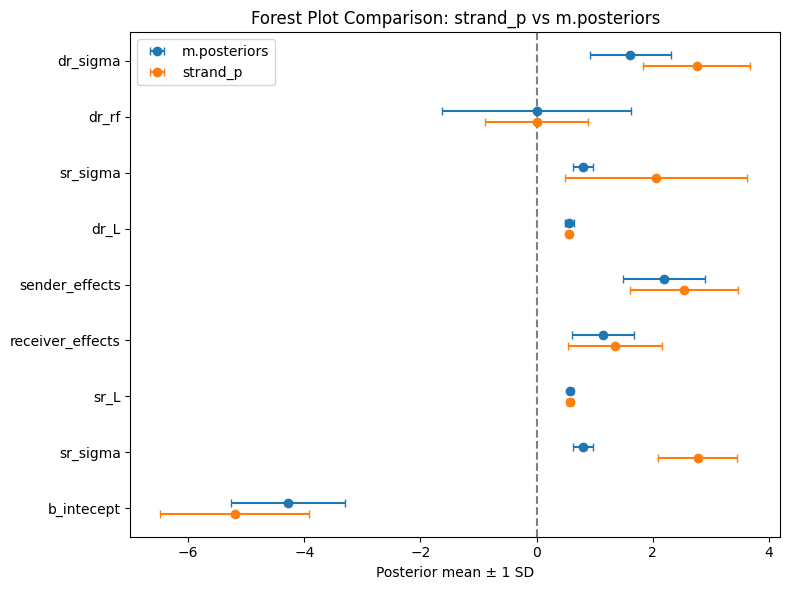

In [67]:
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import numpy2ri
from jax import vmap

strand_posteriors = ro.r['strand_posteriors']
strand_posteriors = strand_to_dict(strand_posteriors)

compare_results(m.posteriors, strand_posteriors)

### Sender receiver,  dyadic effects & block model
#### Simulation

In [83]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R 
#####################################
#
#   Binomial Analyses - Simulated data  
#
########################################

# Clear working space
rm(list = ls())
set.seed(1)
# Load libraries
library(STRAND)
library(rethinking)
library(ggplot2)


# Make data
N_id = 50

# Covariates
Kinship = rlkjcorr( 1 , N_id , eta=1.5 )
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
# Covariates
Kinship = rlkjcorr( 1 , N_id , eta=1.5 )
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
dyadic_preds = array(NA,c(N_id,N_id,1))

dyadic_preds[,,1] = Kinship
#dyadic_preds[,,2] = Dominant
#dyadic_preds[,,3] = Kinship*Dominant

# Set effect sizes
sr_mu = c(0,0)  
sr_sigma = c(2.2, 1.7) 
sr_rho = 0.55
dr_mu = 0 
dr_sigma = 1.5
dr_rho= 0.6
sr_effects_1 = c(1.9, 1.3)
dr_effects_1 = c(1.2)

# Block structure
group_probs_block_size = c(0.25, c(0.25, 0.25)*(1-0.25))

B_1 = matrix(-10,nrow=1,ncol=1)
B_2 = matrix(rnorm(9,0,3),nrow=3,ncol=3)
B_3 = matrix(rnorm(4,0,3),nrow=2,ncol=2)

diag(B_2) = diag(B_2) + 2
diag(B_3) = diag(B_3) + 3.5

B=list(B_1, B_2, B_3)
 
groups_1 = rep("Any",N_id) 
groups_2 = sample( c("Red","White","Blue") , size=N_id , replace=TRUE , prob=group_probs_block_size )
groups_3 = sample( c("Strange", "Charm") , size=N_id , replace=TRUE , prob=c(0.5,0.5) )

groups = data.frame(Intercept=as.numeric(factor(groups_1)), Merica=as.numeric(factor(groups_2)), Quantum=as.numeric(factor(groups_3)))
groups_f = data.frame(Intercept=factor(groups_1), Merica=factor(groups_2), Quantum=factor(groups_3))

#################################################### Simulate SBM + SRM network
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         B = B, 
                         V=3,
                         groups=groups_f,                  
                         sr_mu = sr_mu,  
                         sr_sigma = sr_sigma, 
                         sr_rho = sr_rho,
                         dr_mu = dr_mu,  
                         dr_sigma = dr_sigma, 
                         dr_rho = dr_rho,
                         outcome_mode="bernoulli", 
                         link_mode="logit",                 
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = dyadic_preds,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = dr_effects_1
                         )        

################################################### Organize for model fitting
colnames(G$network)=rownames(G$network)=1:N_id
colnames(Kinship)=rownames(Kinship)=1:N_id
colnames(G$network)=rownames(G$network)=1:N_id
Kinship= matrix(Kinship,ncol=N_id, nrow= N_id)
Kinship= matrix(standardize(Kinship),ncol=N_id, nrow= N_id)
colnames(Kinship)=rownames(Kinship)=1:N_id

model_dat = make_strand_data(outcome=list("Assoc"=G$network),  block_covariates=groups_f, 
                           individual_covariates=data.frame(Mass=Mass), 
                           dyadic_covariates=list(Kinship=Kinship), 
                            outcome_mode = "bernoulli", 
                            link_mode="logit")

# Model the data with STRAND
fit =  fit_block_plus_social_relations_model(data=model_dat,
                            block_regression = ~ Merica + Quantum,
                              focal_regression = ~ Mass,
                              target_regression = ~ Mass,
                              dyad_regression = ~ Kinship,
                              mode="mcmc",
                              stan_mcmc_parameters = list(chains = 1, parallel_chains = 1, refresh = 500,
                                                          iter_warmup = 500, iter_sampling = 500,
                                                          max_treedepth = NULL, adapt_delta = .9)
)

# Check parameter recovery
res = summarize_strand_results(fit)
save(fit, model_dat, file = 'STRAND sim sr dr block.Rdata')

#### Send simulation to python

In [10]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [11]:
%%R
getwd()
library(STRAND)
load('STRAND sim sr dr block.Rdata')
res = summarize_strand_results(fit)

$`Focal effects: Out-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "2.204" "1.845"   "2.624"  
[2,] "focal effects coeffs (out-degree), Mass" "1.652" "0.716"   "2.472"  
     Mean    SD      P      
[1,] "2.227" "0.257" "0"    
[2,] "1.636" "0.544" "0.002"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "1.516" "1.165"   "1.849"  
[2,] "target effects coeffs (in-degree), Mass" "0.842" "0.072"   "1.508"  
     Mean    SD      P      
[1,] "1.534" "0.22"  "0"    
[2,] "0.803" "0.453" "0.032"

$`Dyadic effects`
     Variable                         Median  HPDI:0.05 HPDI:0.95 Mean   
[1,] "dyadic effects sd"              "1.47"  "1.326"   "1.629"   "1.477"
[2,] "dyadic effects coeffs, Kinship" "0.423" "-0.491"  "1.331"   "0.432"
  

#### Model

In [ ]:
# Building model and sampling it ------------------
from main import *
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
data = ro.globalenv['model_dat']
data = {key: list(value) for key, value in zip(data.names, data)}
data = {key: jnp.array(value) for key, value in data.items()}
data['outcomes'] = data['outcomes'].reshape(data['N_id'][0],data['N_id'][0]).T.astype(int)
kinship = data['dyadic_predictors'][0,:,:].reshape(data['N_id'][0],data['N_id'][0]).T
Any = data['block_predictors'][0,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
Merica  = data['block_predictors'][1,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
Quantum  = data['block_predictors'][2,:]-1 # Blocks are vectors of group belonging, index start at 1 so we substract 1
ids = jnp.arange(0,data['N_id'][0])
idx = bi.net.vec_node_to_edgle(jnp.stack([ids, ids], axis = -1))


In [ ]:

@jit
def logit(x):
    return jnp.log(x / (1 - x))

def model3(idx, result_outcomes, dyadic_predictors, focal_individual_predictors, target_individual_predictors, Any, Merica, Quantum):
    # Block ---------------------------------------
    B_any = m.net.block_model(Any,1)
    B_Merica = m.net.block_model(Merica,3)
    B_Quantum = m.net.block_model(Quantum,2)

    ## SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(focal_individual_predictors,target_individual_predictors)

    # Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(dyadic_predictors)
    m.dist.poisson(jnp.exp(B_any + B_Merica + B_Quantum + sr + dr ), obs=result_outcomes)

m.data_on_model = dict(
    idx = idx,
    Any = Any, 
    Merica = Merica, 
    Quantum = Quantum,
    result_outcomes = m.net.mat_to_edgl(data['outcomes']), 
    dyadic_predictors = m.net.mat_to_edgl(kinship),
    focal_individual_predictors = data['individual_predictors'].reshape(1,50),
    target_individual_predictors = data['individual_predictors'].reshape(1,50)
)

m.run(model3) 
summary = m.summary()
summary.loc[['focal_effects[0]', 'target_effects[0]', 'dyad_effects[0]',
'b_ii_Any[0]',
'b_ii_Merica[0]',
'b_ii_Merica[1]',
'b_ii_Merica[2]',
'b_ii_Quantum[0]',
'b_ii_Quantum[1]',
'b_ij_Merica[0, 0]',
'b_ij_Merica[0, 1]',
'b_ij_Merica[1, 0]',
'b_ij_Merica[1, 1]',
'b_ij_Merica[2, 0]',
'b_ij_Merica[2, 1]',
'b_ij_Quantum[0, 0]',
'b_ij_Quantum[0, 1]']]
# focal_effects = 1.9,
# target_effects =  1.3
# dr_effects = 1.2


In [14]:
%%R
getwd()
library(STRAND)
load('tests/STRAND/STRAND sim sr dr block.Rdata')
res$summary

                                            Variable Median HPDI:0.05 HPDI:0.95
1                                   focal effects sd  2.204     1.845     2.624
2            focal effects coeffs (out-degree), Mass  1.652     0.716     2.472
3                                  target effects sd  1.516     1.165     1.849
4            target effects coeffs (in-degree), Mass  0.842     0.072     1.508
5                                  dyadic effects sd   1.47     1.326     1.629
6                     dyadic effects coeffs, Kinship  0.423    -0.491     1.331
7  focal-target effects rho (generalized recipocity)  0.609     0.402     0.762
8             dyadic effects rho (dyadic recipocity)  0.734     0.568     0.899
9                                 offset, Any to Any -0.821    -3.052     1.559
10                              offset, Blue to Blue -4.146     -5.55    -2.174
11                               offset, Blue to Red -9.071   -11.099    -7.284
12                             offset, B

#### Sender receiver, dyadic effects, block model and exposure model

Binomial with rates

## Full model with new version of STRAND

In [14]:
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [27]:
%%R
library(rethinking)
library(igraph)
library(STRAND)
library(ggplot2)

set.seed(1)
# Make data
N_id = 50

# Covariates
Kinship = STRAND::standardize(rlkjcorr( 1 , N_id , eta=1.5 ))
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
dyadic_preds = array(NA,c(N_id,N_id,3))

dyadic_preds[,,1] = Kinship
dyadic_preds[,,2] = Dominant
dyadic_preds[,,3] = Kinship*Dominant

# Set effect sizes
sr_mu = c(0,0)  
sr_sigma = c(2.2, 1.7) 
sr_rho = 0
dr_mu = 0 
dr_sigma = 1.5
dr_rho= 0.8
sr_effects_1 = c(0, 0)
dr_effects_1 = c(0, 0, 0)

# Block structure
group_probs_block_size = c(0.25, c(0.25, 0.25)*(1-0.25))

B_1 = matrix(-10,nrow=1,ncol=1)
B_2 = matrix(rnorm(9,0,3),nrow=3,ncol=3)
B_3 = matrix(rnorm(4,0,3),nrow=2,ncol=2)

diag(B_2) = diag(B_2) + 2
diag(B_3) = diag(B_3) + 3.5

B=list(B_1, B_2, B_3)
 
groups_1 = rep("Any",N_id) 
groups_2 = sample( c("Red","White","Blue") , size=N_id , replace=TRUE , prob=group_probs_block_size )
groups_3 = sample( c("Strange", "Charm") , size=N_id , replace=TRUE , prob=c(0.5,0.5) )

groups = data.frame(Intercept=as.numeric(factor(groups_1)), Merica=as.numeric(factor(groups_2)), Quantum=as.numeric(factor(groups_3)))
groups_f = data.frame(Intercept=factor(groups_1), Merica=factor(groups_2), Quantum=factor(groups_3))
individual = data.frame(Mass=Mass)
groups_f

   Intercept Merica Quantum
1        Any   Blue Strange
2        Any   Blue   Charm
3        Any  White Strange
4        Any  White   Charm
5        Any  White Strange
6        Any   Blue Strange
7        Any   Blue Strange
8        Any  White   Charm
9        Any

   Blue   Charm
10       Any    Red   Charm
11       Any  White   Charm
12       Any    Red Strange
13       Any    Red   Charm
14       Any    Red   Charm
15       Any   Blue   Charm
16       Any    Red   Charm
17       Any    Red Strange
18       Any    Red Strange
19       Any    Red   Charm
20       Any    Red Strange
21       Any    Red   Charm
22       Any  White Strange
23       Any   Blue   Charm
24       Any  White   Charm
25       Any    Red Strange
26       Any   Blue   Charm
27       Any  White   Charm
28       Any  White   Charm
29       Any  White   Charm
30       Any   Blue   Charm
31       Any    Red   Charm
32       Any  White Strange
33       Any  White   Charm
34       Any  White   Charm
35       Any  White Strange
36       Any  White Strange
37       Any    Red Strange
38       Any    Red Strange
39       Any   Blue   Charm
40       Any  White   Charm
41       Any  White Strange
42       Any  White   Charm
43       Any   Blue Strange
44       Any   Blue Strange
45  

Running MCMC with 1 chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   2 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   3 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   4 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   5 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   6 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   7 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   8 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:   9 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration:  10 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  11 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  12 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  13 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  14 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  15 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  16 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  17 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  18 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  19 / 1000 [  1%]  (Warmup) 
Chain 1 Iteration:  20 / 1000 [  2%]  (Warmup) 
Chain 1 It

STRAND: Social network analysis and simulation in R using Stan.
This version of STRAND is: our_dire_reveille.
Loading required package: cmdstanr
This is cmdstanr version 0.9.0
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/sosa/.cmdstan/cmdstan-2.37.0
- CmdStan version: 2.37.0
Loading required package: posterior
This is posterior version 1.6.1

Attaching package: ‘posterior’

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

Loading required package: parallel
rethinking (Version 2.42)

Attaching package: ‘rethinking’

The following objects are masked from ‘package:STRAND’:

    HPDI, inv_logit, logit, rbern, rmvnorm, rmvnorm2, standardize

The following object is masked from ‘package:stats’:

    rstudent


Attaching package: ‘igraph’

The following objects are masked from ‘package:rethinking’:

    compare, normalize

The following object is masked from ‘

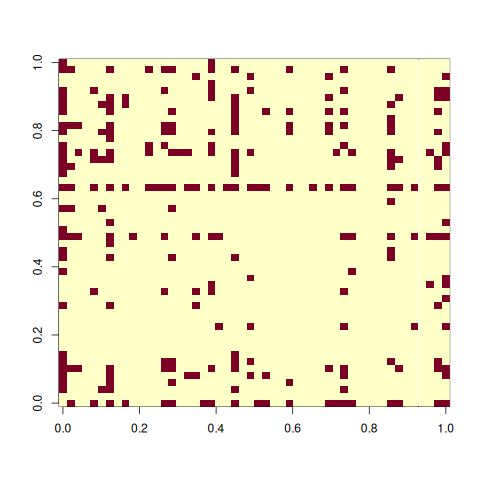

In [4]:
%%R
options(max.print = 100)
library(STRAND)



fit_block_plus_social_relations_model_with_BI = function(data,
                                    block_regression,
                                    focal_regression,
                                    target_regression,
                                    dyad_regression,
                                    mode="mcmc",
                                    return_predicted_network=FALSE,
                                    stan_mcmc_parameters = list(seed = 1, chains = 1, parallel_chains = 1, refresh = 1, iter_warmup = NULL,
                                                                iter_sampling = NULL, max_treedepth = NULL, adapt_delta = NULL, init = NULL),
                                    priors=NULL
                                    )
{

    ############################################################################# Check inputs
    if(attributes(data)$class != "STRAND Data Object"){
        stop("fit_block_plus_social_relations_model() requires a data object of class: STRAND Data Object. Please use make_strand_data() to build your data list.")
    }

    if(!("SRM+SBM" %in% attributes(data)$supported_models)){
        stop("The supplied data are not appropriate for a block plus social relations model. Please ensure that self_report data are single sampled and a group variable is provided.")
    }

    if(data$N_individual_predictors==0 & focal_regression != ~ 1){
        stop("No individual covariate data has been provided. focal_regression must equal ~ 1 ")
    }

    if(data$N_individual_predictors==0 & target_regression != ~ 1){
        stop("No individual covariate data has been provided. target_regression must equal ~ 1 ")
    }

    if(data$N_dyadic_predictors==0 & dyad_regression != ~ 1){
        stop("No individual covariate data has been provided. dyad_regression must equal ~ 1 ")
    }

    if(data$N_block_predictors==0 & block_regression != ~ 1){
        stop("No block covariate data has been provided. block_regression must equal ~ 1 ")
    }

    if(attributes(data)$directed == "undirected" & (focal_regression != target_regression) ){
        warning("You have an undirected outcome, but focal_regression and target_regression are not equal.
        In undirected models, these should be the same. Rethink your model.")
    }

    ############################################################################# Prepare data and parse formulas
     ind_names = colnames(data$individual_predictors)
     dyad_names = names(data$dyadic_predictors)

     ################################################################ Dyad model matrix
     if(data$N_dyadic_predictors>0){
     dyad_dims = c(data$N_id, data$N_id, length(dyad_names))

     dyad_dat = list()
     for(i in 1:dyad_dims[3]){
      dyad_dat[[i]] = c(data$dyadic_predictors[[i]])
     }

     #dyad_dat = do.call(rbind.data.frame, dyad_dat)
     dyad_dat = do.call(data.frame, dyad_dat)
     colnames(dyad_dat) = dyad_names
     dyad_model_matrix = model_matrix_strand(dyad_regression , dyad_dat, "dyad_regression")

     dyad_dat_out = array(NA, c(dyad_dims[1], dyad_dims[2], ncol(dyad_model_matrix)))
     for(i in 1:ncol(dyad_model_matrix)){
      dyad_dat_out[,,i] = matrix(dyad_model_matrix[,i], nrow=dyad_dims[1], ncol=dyad_dims[2])
     }

     dimnames(dyad_dat_out)[[3]] = colnames(dyad_model_matrix)
     data$dyad_set = dyad_dat_out
     } else{
      data$dyad_set = array(1, c(data$N_id, data$N_id, 1))
     }

     ################################################################ Individual model matrix
     if(data$N_individual_predictors>0){
      data$focal_set = model_matrix_strand(focal_regression, data$individual_predictors, "focal_regression")
      data$target_set = model_matrix_strand(target_regression , data$individual_predictors, "target_regression")
     } else{
      data$focal_set = matrix(1,nrow=data$N_id, ncol=1)
      data$target_set = matrix(1,nrow=data$N_id, ncol=1)
     }

    data$N_params = c(ncol(data$focal_set), ncol(data$target_set), dim(data$dyad_set)[3])

    ################################################################ Block model matrix
     if(data$N_block_predictors>0){
      data$block_set = model_matrix_strand(block_regression , data$block_predictors, "block_regression")
     } else{
      data$block_set = as.array(matrix(1, nrow=data$N_id, ncol=1))
      colnames(data$block_set) = "(Intercept)"
     }

     data$N_group_vars = ncol(data$block_set)
     data$N_groups_per_var = rep(NA, data$N_group_vars)

     for(i in 1:data$N_group_vars){
      data$N_groups_per_var[i] = length(unique(data$block_set[,i]))
     }

     data$N_groups_per_var = as.array(data$N_groups_per_var)

     data$max_N_groups = max(data$N_groups_per_var)

    ############### Priors
    data$export_network = ifelse(return_predicted_network==TRUE, 1, 0)

    if(is.null(priors)){
      data$priors =  make_priors()
      } else{
    data$priors = priors
      }

    ############################################################################# Fit model
    if(mode != 'BI'){
      model = cmdstanr::cmdstan_model(paste0(path.package("STRAND"),"/","block_plus_social_relations_model.stan"))
    }

    data$individual_predictors = NULL
    data$dyadic_predictors = NULL
    data$block_predictors = NULL

    if(mode=="mcmc"){
      fit = model$sample(
        data = unclass(data),
        seed = stan_mcmc_parameters$seed,
        chains = stan_mcmc_parameters$chain,
        parallel_chains = stan_mcmc_parameters$parallel_chains,
        refresh = stan_mcmc_parameters$refresh,
        iter_warmup = stan_mcmc_parameters$iter_warmup,
        iter_sampling = stan_mcmc_parameters$iter_sampling,
        max_treedepth = stan_mcmc_parameters$max_treedepth,
        adapt_delta = stan_mcmc_parameters$adapt_delta,
        init = stan_mcmc_parameters$init
        )
       }

    if(mode=="vb"){
     print("Variational inference is fast, but not always dependable. We recommend using vb only for test runs.")
     fit = model$pathfinder(data = unclass(data))
     }

    if(mode=="optim"){
     print("Optimazation is fast, but not always dependable. We recommend using optim only for test runs.")
     fit = model$optimize(data = unclass(data), seed = 123)
     }

    if(mode=="BI"){
      print("The BI backend is a new option, we recommened cross-checking final model fits against Stan models fit with 'mcmc'.")
      fit = fit_with_BI(data, stan_mcmc_parameters)
    }

    if(! mode %in% c("mcmc", "vb", "optim", "BI") ){
     stop("Must supply a legal mode value: mcmc, vb, optim, or BI.")
    }

    bob = list(data=data, fit=fit, return_predicted_network=return_predicted_network )
    attr(bob, "class") = "STRAND Model Object"
    attr(bob, "fit_type") = mode
    attr(bob, "model_type") = "SRM+SBM"

    return(bob)
}




 convert_posterior = function(posteriors){
  np = reticulate::import('numpy')
  R_list = reticulate::py_to_r(posteriors)
  for(a in 1:length(R_list)){
    R_list[[a]] = reticulate::py_to_r(np$array(R_list[[a]]))
  }
  return(R_list)
}



summarize_bsrm_results = function(input, include_samples=TRUE, HPDI=0.9){
    if(attributes(input)$class != "STRAND Model Object"){
        stop("summarize_bsrm_results() requires a fitted object of class: STRAND Model Object. Please use fit_block_plus_social_relations_model() to run your model.")
    }

    ###################################################### Create samples 
    outcome_mode = input$data$outcome_mode 

    if(attr(input, "fit_type")=="BI"){
        BI = TRUE
    }else{
        BI = FALSE
            if(attributes(input)$fit_type != "mcmc"){
            if(attributes(input)$fit_type == "vb"){
         warning("Final, publication-ready model fits for STRAND models should always be produced using MCMC! Variational inference via Pathfinder can be used in Stan
              during experimental model runs, but final inferences should be based on MCMC sampling. In our tests, Pathfinder results are decently similar to MCMC results, 
              but often failed to recover strong true effects. ")  
         } else{
         stop("Fitted results can only be reorganized for STRAND model objects fit using MCMC. Variational inference or optimization can be used in Stan
              during experimental model runs, but final inferences should be based on MCMC sampling.")  
      }    
     }
    }

    ################### Network model parameters
      if(BI==FALSE){
    stanfit = posterior::as_draws_rvars(input$fit$draws())

    sr_sigma = posterior::draws_of(stanfit$"sr_sigma")
    sr_L = posterior::draws_of(stanfit$"sr_L") 
    sr_raw = posterior::draws_of(stanfit$"sr_raw")

    dr_L = posterior::draws_of(stanfit$"dr_L")
    dr_raw = posterior::draws_of(stanfit$"dr_raw") 
    dr_sigma = posterior::draws_of(stanfit$"dr_sigma")

    error_sigma = posterior::draws_of(stanfit$"error_sigma")
    
    if(dim(input$data$block_set)[2]>0)
    block_effects = posterior::draws_of(stanfit$"block_effects")

    if(dim(input$data$focal_set)[2]>1)
    focal_effects = posterior::draws_of(stanfit$"focal_effects") 

    if(dim(input$data$target_set)[2]>1)
    target_effects = posterior::draws_of(stanfit$"target_effects")  

    if(dim(input$data$dyad_set)[3]>1)
    dyad_effects = posterior::draws_of(stanfit$"dyad_effects")
      }

    ################### Network model parameters BI
    if(BI==TRUE){
    samps = convert_posterior(input$fit$posteriors)

    sr_sigma = samps$sr_sigma
    sr_L = samps$sr_L 
    sr_raw = aperm(samps$sr_raw, perm = c(1, 3, 2))

    dr_L = samps$dr_L 
    dr_raw = samps$dr_raw
    dr_sigma = samps$dr_sigma

    error_sigma = dr_sigma     
    for(i in 1:dim(error_sigma)[1]) 
    error_sigma[i,1] = NA      
    
    if(dim(input$data$block_set)[2]>0)
    block_effects = samps$block_effects

    if(dim(input$data$focal_set)[2]>1){
      focal_effects = samps$focal_effects
      focal_effects = focal_effects[, -1, drop = FALSE]
    }

    if(dim(input$data$target_set)[2]>1){
      target_effects = samps$target_effects
      target_effects = target_effects[, -1, drop = FALSE]
    }


    if(dim(input$data$dyad_set)[3]>1){
      dyad_effects = samps$dyad_effects
      dyad_effects = dyad_effects[, -1, drop = FALSE]
    }
    
      }

    ################### Get index data for block-model samples
    block_indexes = c()
    block_indexes[1] = 0
    for(q in 1:input$data$N_group_vars){ 
    block_indexes[1+q] = input$data$N_groups_per_var[q]*input$data$N_groups_per_var[q] + block_indexes[q]
    }

    ################### Convert the block-model effects into an array form
    B = list()
    for(q in 1:input$data$N_group_vars){
      B[[q]] = array(NA, c(dim(block_effects)[1], input$data$N_groups_per_var[q], input$data$N_groups_per_var[q]  ))

      for(s in 1:dim(block_effects)[1]){
       B[[q]][s,,] =  array(block_effects[s,(block_indexes[q]+1):(block_indexes[q+1])], c(input$data$N_groups_per_var[q], input$data$N_groups_per_var[q]))
      }
    }   

    srm_samples = list(
            block_parameters=B,

            focal_target_sd=sr_sigma,
            focal_target_L=sr_L,
            focal_target_random_effects=sr_raw,

            dyadic_sd = dr_sigma,
            dyadic_L = dr_L,
            dyadic_random_effects=dr_raw,
            error_sd = error_sigma
        )

    if(dim(input$data$focal_set)[2]>1)
    srm_samples$focal_coeffs = focal_effects

    if(dim(input$data$target_set)[2]>1)
    srm_samples$target_coeffs = target_effects

    if(dim(input$data$dyad_set)[3]>1)
    srm_samples$dyadic_coeffs = dyad_effects

    samples = list(srm_model_samples=srm_samples)

    if(BI==FALSE){
      if(input$return_predicted_network == TRUE){
        samples$predicted_network_sample = posterior::draws_of(stanfit$"p")
        }
    }    

    ###################################################### Create summary stats 
     results_list = list()

    ################### SRM model
     Q1 = dim(input$data$focal_set)[2]-1
     Q2 = dim(input$data$target_set)[2]-1
     Q3 = dim(input$data$dyad_set)[3]-1

     results_srm_focal = matrix(NA, nrow=(1+Q1) , ncol=7)
     results_srm_target = matrix(NA, nrow=(1+Q2) , ncol=7)
     results_srm_dyadic = matrix(NA, nrow=(1+Q3) , ncol=7)

    ######### Calculate all focal effects
     results_srm_focal[1,] = sum_stats("focal effects sd", samples$srm_model_samples$focal_target_sd[,1], HPDI)
     if(Q1>0){
     coeff_names = colnames(input$data$focal_set)[-1]
        for(i in 1:Q1){
     results_srm_focal[1+i,] = sum_stats(paste0("focal effects coeffs (out-degree), ", coeff_names[i] ), samples$srm_model_samples$focal_coeffs[,i], HPDI)
        }
      }

      results_list[[1]] = results_srm_focal

    ######### Calculate all target effects
     results_srm_target[1,] = sum_stats("target effects sd", samples$srm_model_samples$focal_target_sd[,2], HPDI)
     if(Q2>0){
     coeff_names = colnames(input$data$target_set)[-1]
        for(i in 1:Q2){
     results_srm_target[1+i,] = sum_stats(paste0("target effects coeffs (in-degree), ", coeff_names[i] ), samples$srm_model_samples$target_coeffs[,i], HPDI)
        }
      }

      results_list[[2]] = results_srm_target

    ######### Calculate all dyad effects
     results_srm_dyadic[1,] = sum_stats("dyadic effects sd", c(samples$srm_model_samples$dyadic_sd), HPDI)
     if(Q3>0){
     coeff_names = dimnames(input$data$dyad_set)[[3]][-1]
        for(i in 1:Q3){
     results_srm_dyadic[1+i,] = sum_stats(paste0("dyadic effects coeffs, ", coeff_names[i] ), samples$srm_model_samples$dyadic_coeffs[,i], HPDI)
        }
      }
     results_list[[3]] = results_srm_dyadic

    ######### Calculate all block effects
     results_srm_base = matrix(NA, nrow=3 + dim(block_effects)[2], ncol=7)
     results_srm_base[1,] = sum_stats("focal-target effects rho (generalized recipocity)", samples$srm_model_samples$focal_target_L[,2,1], HPDI)
     results_srm_base[2,] = sum_stats("dyadic effects rho (dyadic recipocity)", samples$srm_model_samples$dyadic_L[,2,1], HPDI)

        if(outcome_mode == 4){
        results_srm_base[3,] = sum_stats("error sd", c(samples$srm_model_samples$error_sd), HPDI)
        } else{
        results_srm_base[3,] = c("error sd", rep(NA,6))     
        }

 
     group_ids_character_df = cbind(rep("Any",input$data$N_id),attr(input$data, "group_ids_character"))

     if(is.null(colnames(group_ids_character_df))){
        colnames(group_ids_character_df) = paste0("(NoBlockingVars)", 1:ncol(group_ids_character_df))
     }
     
     colnames(group_ids_character_df)[1] = "(Intercept)"

     in_IDs = colnames(input$data$block_set)
     all_IDs = colnames(group_ids_character_df)
     group_ids_character_df = group_ids_character_df[,match(in_IDs, all_IDs), drop = FALSE]

     group_id_levels = append("Any", attr(input$data, "group_ids_levels"), 1)
     names(group_id_levels)[1]= "(Intercept)"
     
     ticker = 0
     for(q in 1:input$data$N_group_vars){
      group_ids_character = levels(factor(group_ids_character_df[,q]))
      test_sorting = group_id_levels[[which(names(group_id_levels) == colnames(group_ids_character_df)[q])]]
      if(all(group_ids_character==test_sorting)==FALSE){
        stop("Factors not sorted correctly.")
      }

      for(b1 in 1:input$data$N_groups_per_var[q]){
      for(b2 in 1:input$data$N_groups_per_var[q]){
       ticker = ticker + 1  
      results_srm_base[ 3 + ticker,] = sum_stats(paste0("offset, ", group_ids_character[b1], " to ", group_ids_character[b2]), 
                                                                         samples$srm_model_samples$block_parameters[[q]][,b1,b2], HPDI)
     }}

     }
     
     results_list[[4]] = results_srm_base

   ############# Finally, merge all effects into a list
     for(i in 1:4)
     colnames(results_list[[i]]) = c("Variable", "Median", paste("HPDI", (1-HPDI)/2, sep=":"), paste("HPDI", (1+HPDI)/2, sep=":"), "Mean","SD","P") 

     names(results_list) = c( "Focal effects: Out-degree", "Target effects: In-degree", "Dyadic effects", "Other estimates")
          
   results_out = rbind( results_srm_focal, results_srm_target,results_srm_dyadic, results_srm_base)
   
   df = data.frame(results_out)
   colnames(df) = c("Variable", "Median", paste("HPDI", (1-HPDI)/2, sep=":"), paste("HPDI", (1+HPDI)/2, sep=":"), "Mean","SD","P") 

   res_final = list(summary=df, summary_list=results_list)

  if(include_samples==TRUE){
    res_final$samples=samples
   }

   print(results_list)

    attr(res_final, "class") = "STRAND Results Object"
    return(res_final)
}


############################ Test models 
# Load libraries
library(rethinking)
library(igraph)
library(STRAND)
library(ggplot2)

set.seed(1)
# Make data
N_id = 50

# Covariates
Kinship = STRAND::standardize(rlkjcorr( 1 , N_id , eta=1.5 ))
Dominant = ceiling(rlkjcorr( 1 , N_id , eta=1.5 ) - 0.1)
Mass = rbern(N_id, 0.4)

# Organize into list
dyadic_preds = array(NA,c(N_id,N_id,3))

dyadic_preds[,,1] = Kinship
dyadic_preds[,,2] = Dominant
dyadic_preds[,,3] = Kinship*Dominant

# Set effect sizes
sr_mu = c(0,0)  
sr_sigma = c(2.2, 1.7) 
sr_rho = 0
dr_mu = 0 
dr_sigma = 1.5
dr_rho= 0.8
sr_effects_1 = c(0, 0)
dr_effects_1 = c(0, 0, 0)

# Block structure
group_probs_block_size = c(0.25, c(0.25, 0.25)*(1-0.25))

B_1 = matrix(-10,nrow=1,ncol=1)
B_2 = matrix(rnorm(9,0,3),nrow=3,ncol=3)
B_3 = matrix(rnorm(4,0,3),nrow=2,ncol=2)

diag(B_2) = diag(B_2) + 2
diag(B_3) = diag(B_3) + 3.5

B=list(B_1, B_2, B_3)
 
groups_1 = rep("Any",N_id) 
groups_2 = sample( c("Red","White","Blue") , size=N_id , replace=TRUE , prob=group_probs_block_size )
groups_3 = sample( c("Strange", "Charm") , size=N_id , replace=TRUE , prob=c(0.5,0.5) )

groups = data.frame(Intercept=as.numeric(factor(groups_1)), Merica=as.numeric(factor(groups_2)), Quantum=as.numeric(factor(groups_3)))
groups_f = data.frame(Intercept=factor(groups_1), Merica=factor(groups_2), Quantum=factor(groups_3))
individual = data.frame(Mass=Mass)


#################################################### Simulate SBM + SRM network
G = simulate_sbm_plus_srm_network(N_id = N_id, 
                         B = B, 
                         V=3,
                         groups=groups,                  
                         sr_mu = sr_mu,  
                         sr_sigma = sr_sigma, 
                         sr_rho = sr_rho,
                         dr_mu = dr_mu,  
                         dr_sigma = dr_sigma, 
                         dr_rho = dr_rho,
                         error_sigma = 1.0,
                         outcome_mode="bernoulli", 
                         link_mode="logit",                 
                         individual_predictors = data.frame(Mass=Mass),
                         dyadic_predictors = dyadic_preds,
                         individual_effects = matrix(sr_effects_1,nrow=2,ncol=1),
                         dyadic_effects = dr_effects_1
                         )      

image(G$network)

################################################################################################ Fit STRAND
# Create the STRAND data object
# Add row and colnames
name_vec = paste("Individual", 1:N_id)
rownames(G$network) = colnames(G$network) = name_vec
rownames(G$samps) = colnames(G$samps) = name_vec
rownames(Kinship) = colnames(Kinship) = name_vec
rownames(Dominant) = colnames(Dominant) = name_vec
rownames(groups_f) = name_vec
rownames(individual) = name_vec

model_dat = make_strand_data(outcome=list(Association = G$network),  
                             block_covariates=groups_f, 
                             individual_covariates=individual, 
                             dyadic_covariates=list(Kinship=Kinship, Dominant=Dominant),
                             outcome_mode="bernoulli", 
                             link_mode="logit"
                             )

fit1 = fit_block_plus_social_relations_model_with_BI(
    data=model_dat,
    block_regression = ~ Merica + Quantum,
    focal_regression = ~ Mass,
    target_regression = ~ Mass,
    dyad_regression = ~ Kinship + Dominant + Kinship * Dominant,
    mode="mcmc",
    stan_mcmc_parameters = list(
      chains = 1,
      iter_warmup = 500 ,
      iter_sampling = 500 ,
      max_treedepth = 12 ,
      refresh = 1,
      adapt_delta = 0.96)
  )

res1 = summarize_bsrm_results(fit1)


In [ ]:
%%R
save(fit1, model_dat, file = 'STRAND.Rdata')

### BI

In [84]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [90]:
%%R
library(STRAND)
load('STRAND.Rdata')
res = summarize_strand_results(fit1)
strand_posteriors = res$samples$srm_model_samples

$`Focal effects: Out-degree`
     Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "3.372"  "2.292"       Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "focal effects sd"                        "3.372"  "2.292"   "4.462"  
[2,] "focal effects coeffs (out-degree), Mass" "-0.091" "-1.84"   "1.61"   
     Mean     SD      P      
[1,] "3.451"  "0.703" "0"    
[2,] "-0.077" "1.027" "0.464"

$`Target effects: In-degree`
     Variable                                  Median  HPDI:0.05 HPDI:0.95
[1,] "target effects sd"                       "2.743" "1.957"   "3.748"  
[2,] "target effects coeffs (in-degree), Mass" "0.452" "-0.775"  "2.113"  
     Mean    SD      P      
[1,] "2.815" "0.579" "0"    
[2,] "0.466" "0.907" "0.302"

$`Dyadic effects`
     Variable                                  Median   HPDI:0.05 HPDI:0.95
[1,] "dyadic effects sd"                       "3.179"  "2.253"   "4.427"  

In [86]:
from functools import partial
from BI import bi
import jax.numpy as jnp
import numpy as np
m = bi(platform='cpu')
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from rpy2.robjects import numpy2ri
fit1 = ro.globalenv['fit1']
r_list = fit1.rx2('data') 

with localconverter(ro.default_converter + numpy2ri.converter):
    py_data = dict(zip(r_list.names, list(r_list)))

jax_data = {k: jnp.array(v) for k, v in py_data.items()}

network = m.net.mat_to_edgl(jax_data['outcomes'][:,:,0])
dyadic_predictors = m.net.prepare_dyadic_effect(jax_data['dyad_set'])[:,:,1:] # removing intercept

sender_predictors = jax_data['focal_set'][:,1].T.reshape(1,50)
receiver_predictors = jax_data['target_set'][:,1].T.reshape(1,50)

block_predictors = jax_data['block_set']
Any = block_predictors[:,0]-1
Merica = block_predictors[:,1] -1
Quantum = block_predictors[:,2] -1
N_grp_Any, N_per_grp_Any =  jnp.unique(Any, return_counts=True)
N_grp_Merica, N_per_grp_Merica =  jnp.unique(Merica, return_counts=True)
N_grp_Quantum, N_per_gr_Quantum =  jnp.unique(Quantum, return_counts=True)
N_grp_Any = N_grp_Any.shape[0]
N_grp_Merica = N_grp_Merica.shape[0]
N_grp_Quantum = N_grp_Quantum.shape[0]

jax.local_device_count 16


In [109]:

def model(network, dyadic_predictors, sender_predictors, receiver_predictors, Merica, Quantum, Any):

    # Block ---------------------------------------
    B_any = m.net.block_model(Any,N_grp_Any,N_per_grp_Any, name = 'intercept')
    B_Merica = m.net.block_model(Merica,N_grp_Merica,N_per_grp_Merica, name = 'Merica')
    B_Quantum = m.net.block_model(Quantum,N_grp_Quantum,N_per_gr_Quantum, name = 'Quantum')
    
    ## SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(sender_predictors,receiver_predictors, 
    s_sd=2.5, r_sd=2.5, sr_sd = 2.5 )

    # Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(dyadic_predictors,d_sd=2.5, dr_sd=2.5)

    m.dist.bernoulli(logits = B_any + B_Merica + B_Quantum + sr + dr, obs=network)

m.data_on_model = dict(
    Any = Any, 
    Merica = Merica, 
    Quantum = Quantum,
    network = network, 
    dyadic_predictors = dyadic_predictors, # Can be a jax array of multiple dimensions
    sender_predictors = sender_predictors.T,
    receiver_predictors = receiver_predictors.T
)

m.fit(model, num_samples = 500, num_warmup = 500, num_chains = 1, thinning = 1, progress_bar = True)
m.summary()
summary = m.tab_summary

sample: 100%|██████████| 1000/1000 [00:33<00:00, 29.85it/s, 63 steps of size 5.43e-02. acc. prob=0.94]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide

/home/sosa/work/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide



In [120]:
tmp = summary[summary.index.str.contains('dyad_effects|receiver_effects|sender_effects|b_')]
tmp.index = [
    'Any to An', 
    'Blue to Blue', 'Blue to Red', 'Blue to White', 
    'Red to Blue', 'Red to Red', 'Red to White',
    'White to Blue', 'White to Red', 'White to White',
    'Charm to Charm', 'Charm to Strange', 'Strange to Charm', 'strange to Strange',
    'Kinship', 'Dominant', 'Kinship x Dominant',
    'receiver_effects', 'sender_effects'
]
tmp

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Any to An,-0.73,1.41,-3.01,1.37,0.11,0.07,159.61,208.24,NaN
Blue to Blue,-8.54,1.50,-10.75,-6.05,0.17,0.10,79.92,146.96,NaN
Blue to Red,-1.03,1.34,-3.22,0.91,0.16,0.06,70.07,238.91,NaN
Blue to White,-6.92,1.43,-9.32,-4.92,0.12,0.07,155.09,283.56,NaN
Red to Blue,-3.34,1.35,-5.57,-1.47,0.11,0.05,139.87,264.78,NaN
Red to Red,-6.41,1.38,-8.60,-4.27,0.13,0.06,109.53,96.90,NaN
Red to White,-8.70,1.57,-11.41,-6.47,0.11,0.07,186.55,201.92,NaN
White to Blue,-9.70,1.44,-11.93,-7.52,0.11,0.06,185.09,202.87,NaN
White to Red,-7.98,1.40,-10.10,-5.91,0.12,0.08,145.15,207.36,NaN
White to White,-10.00,1.55,-12.41,-7.60,0.13,0.07,134.82,220.45,NaN


In [121]:
%%R
res$summary[, !colnames(res$summary) %in%  'P']

                                            Variable Median HPDI:0.05 HPDI:0.95
1                                   focal effects sd  3.372     2.292     4.462
2            focal effects coeffs (out-degree), Mass -0.091     -1.84      1.61
3                                  target effects sd  2.743     1.957     3.748
4            target effects coeffs (in-degree), Mass  0.452    -0.775     2.113
5                                  dyadic effects sd  3.179     2.253     4.427
6                     dyadic effects coeffs, Kinship  0.453    -0.096     0.952
7                    dyadic effects coeffs, Dominant -0.346    -1.184     0.381
8            dyadic effects coeffs, Kinship:Dominant -1.154    -2.349    -0.124
9  focal-target effects rho (generalized recipocity)  0.011    -0.301     0.277
10            dyadic effects rho (dyadic recipocity)

  0.484      0.21     0.757
11      0.21     0.757
11                                          error sd   <NA>      <NA>      <NA>
12                                offset, Any to Any -0.596    -3.419     2.333
13                              offset, Blue to Blue  -0.01    -2.176     1.978
14                               offset, Blue to Red -7.087    -9.257    -4.588
15                             offset, Blue to White -0.322    -2.311     1.761
16                               offset, Red to Blue -5.749    -7.881    -3.556
17                                offset, Red to Red -2.626     -4.69    -0.693
18                              offset, Red to White -5.133    -7.382    -3.071
19                             offset, White to Blue -7.507    -9.815     -5.39
20                              offset, White to Red -8.411   -10.862    -6.327
21                            offset, White to White   -6.7    -9.077    -4.608
22                            offset, Charm to Charm -8.543   -11.138

# New block approach

In [12]:
def import_block_predictors(block_predictors, names = None, index1 = False):
        #! index1 for R users
        N_id = block_predictors.shape[0]
        if block_predictors.ndim > 1:
            N_vars = block_predictors.shape[1]
            N_groups_per_var = block_predictors.max(axis=0).astype(int)
            max_N_groups_per_var = max(N_groups_per_var)
        else:
            N_vars = 1
            N_groups_per_var = block_predictors.max(axis=0).astype(int)
            max_N_groups_per_var = jnp.array([1])
        jnp.unique(block_predictors, return_counts=True)
        N_per_group = jnp.ones((N_vars, max_N_groups_per_var))
        for a in range(N_vars):
            N_per_group = N_per_group.at[a,:N_groups_per_var[a]].set(jnp.unique(block_predictors[:,a], return_counts = True)[1])
        N_per_group
        N_pars = (N_groups_per_var * N_groups_per_var).sum()
    
        B_V = B_I = B_J = B_In = B_Base = B_SS = jnp.zeros((N_vars, max_N_groups_per_var, max_N_groups_per_var))
        for v in range(N_vars):
            for i in range(N_groups_per_var[v]):
                for j in range(N_groups_per_var[v]):
                    B_V= B_V.at[v,i,j].set(v)
                    B_I = B_I.at[v,i,j].set(i)
                    B_J= B_J.at[v,i,j].set(j)
                    B_In = B_In.at[v,i,j].set(1)
                    B_Base =  B_Base.at[v,i,j].set(0.1 if i == j else 0.01)        
                    B_SS = B_SS.at[v,i,j].set(jnp.sqrt(N_per_group[v,i]*0.5 + N_per_group[v,j]*0.5))
    
        B_SS = B_SS.flatten()
        B_V = B_V.flatten()
        B_I = B_I.flatten()
        B_J = B_J.flatten()
        B_In = B_In.flatten()
        B_Base = B_Base.flatten()
        dat_B = jnp.stack([B_V, B_I, B_J, B_In, B_Base, B_SS], axis = -1)
        dat_B = dat_B[jnp.where(B_In==1)]
        Sigma = jnp.full((N_pars,), 2.5)
        Mu = m.link.logit(dat_B[:,-2]/dat_B[:,-1])
    
        dat_B = jnp.concatenate([dat_B, Mu[:,None], Sigma[:,None]], axis = 1)


        def build_block_tensor(dat_B, block_predictors):
            dat_B2 = dat_B[:, :3].astype(int)
            dat_B2_col0 = dat_B2[:, 0]
            dat_B2_col1 = dat_B2[:, 1]
            dat_B2_col2 = dat_B2[:, 2]
            block_preds_indexed = block_predictors[:, dat_B2_col0]
            scrap_i_matrix = (block_preds_indexed == dat_B2_col1)
            scrap_j_matrix = (block_preds_indexed == dat_B2_col2)
            # 5. Transpose the matrices to get a shape of (N_pars, N_id)
            scrap_i_T = scrap_i_matrix.T
            scrap_j_T = scrap_j_matrix.T
            Y_optimized = (scrap_i_T[:, :, np.newaxis] * scrap_j_T[:, np.newaxis, :]).astype(int)
            return  jnp.array(Y_optimized.transpose(1,2,0))
        
        block_tensor = build_block_tensor(dat_B, block_predictors)

        Block_edgl =  []
        for a in range(block_tensor.shape[2]):
            Block_edgl.append(m.net.mat_to_edgl(block_tensor[:,:,a]))  
        Block_edgl = jnp.transpose(jnp.stack(Block_edgl), (1,2,0))

        Block_edgl = Block_edgl
        dat_B = dat_B
        block_names = names
        N_vars_Block = N_vars
        max_N_groups_per_var = max_N_groups_per_var
        N_pars = N_pars
        if index1:
            block_predictors = block_predictors - 1
        else:
            block_predictors = block_predictors

        return dat_B, Block_edgl

def block_effect_srm_class(block_predictors, names = ['Any', 'Merica', 'Quantum'], index1 = True, sample = False):
    dat_B, block_edgl = import_block_predictors(block_predictors = block_predictors, names = ['Any', 'Merica', 'Quantum'], index1 = True)
    coefs = m.dist.normal(dat_B[:,-2], dat_B[:,-1], name = 'block_effects',  sample = sample)
    t = jnp.sum(coefs * block_edgl, axis=2)
    return jnp.stack([t[:,1], t[:,0]]).T


In [ ]:
def model(network, dyadic_predictors, sender_predictors, receiver_predictors,block_predictors):
    # Block ---------------------------------------
    #B = block_effect_srm_class(srm)
    B = block_effect_srm_class(block_predictors)

    ## SR shape =  N individuals---------------------------------------
    sr =  m.net.sender_receiver(sender_predictors, receiver_predictors)

    # Dyadic shape = N dyads--------------------------------------  
    dr = m.net.dyadic_effect(shape = sr.shape[0])

    m.dist.bernoulli(logits = B + sr + dr , obs=network, name = 'network')
m.data_on_model = dict(
    block_predictors = block_predictors,
    network = network, 
    dyadic_predictors = dyadic_predictors, # Can be a jax array of multiple dimensions
    sender_predictors = sender_predictors,
    receiver_predictors = receiver_predictors
)

m.fit(model)
m.summary()

## BISONR (WIP)

In [3]:
df = pd.read_csv('tests/STRAND/bison sim data.csv')
df.shape

(45, 7)

### Binary

In [4]:
num_rows = df.shape[0] 
N_id = len(jnp.unique(jnp.stack([jnp.array(df.node_1_id.values), jnp.array(df.node_2_id.values)]).flatten()))
N_dyads = jnp.arange(0,(N_id*(N_id-1))/2)
num_edges = len(N_dyads)

num_fixed = 0 # Number of fixed effect parameters
num_random = 0 # Number of random effect parameters
num_random_groups = 0 # Number of random effect groups

event = jnp.array(df.event.values) # Outcome for each data point (presence/absence)
divisor = jnp.array(df.duration.values) # Duration of each observation
dyad_ids = jnp.arange(0,(N_id*(N_id-1))/2, dtype= jnp.int32)  # Dyad IDs of each observation for indexing edge weights

design_fixed = 0 # Design matrix for fixed effects
design_random = 0 # Design matrix for random effects.
random_group_index = 0 # Index for groupings for random effects


prior_edge_mu = 0 #  Prior mean for fixed effects
prior_edge_sigma  =  2.5 #  Prior standard deviation for fixed effects
prior_fixed_mu  = 0 #  Prior mean for fixed effects
prior_fixed_sigma  = 2.5 #  Prior standard deviation for fixed effects
prior_random_mean_mu  = 0 #  Prior mean on centralisation of random effects
prior_random_mean_sigma  = 1 #  Prior standard deviation on centralisation of random effects
prior_random_std_sigma  = 1 #  Prior standard deviation on dispersion of random effects
prior_zero_prob_alpha  = 1 #  Prior alpha on zero inflation
prior_zero_prob_beta  = 1 #  Prior beta on zero inflation
priors_only  = 0 # Whether to sample from only the priors
partial_pooling  = 0 # Whether to pool edge weight estimates
zero_inflated  = False # Whether to use zero-inflated edge model

edge_weight = jnp.zeros((num_edges,)) # Parameters for edge weights.
beta_fixed = jnp.zeros((num_fixed,)) # Parameters for fixed effects.
beta_random = jnp.zeros((num_random,)) # Parameters for random effects.
random_group_mu = jnp.zeros((num_random_groups,)) # Hyperpriors for random effects (mean).
random_group_sigma = jnp.zeros((num_random_groups,)) # Hyperpriors for random effects (std. dev.).
edge_sigma = jnp.zeros((partial_pooling,)) # Random effect for edge weight pooling.
#zero_prob = jnp.zeros((zero_inflated,)) # Zero inflated parameter for probability of zeroes.
if zero_inflated:
    zero_prob = 0
else :
    zero_prob = 0.5

In [5]:
predictor = jnp.ones((num_rows,)) + edge_weight[dyad_ids] + jnp.repeat(0, num_rows) + jnp.repeat(0, num_rows) 
#design_fixed * beta_fixed
#design_random * beta_random

In [9]:
zero_prob = numpyro.distributions.Beta(1.0, 1.0)
predictor = jnp.ones(event.shape)
prob = jax.nn.sigmoid(predictor)

lk("obs", numpyro.distributions.ZeroInflatedDistribution(
    numpyro.distributions.Binomial(total_count=divisor, probs=prob), 
    gate=0.51848227
), obs=event)

lk("obs", numpyro.distributions.ZeroInflatedDistribution(
    numpyro.distributions.Poisson(rate=event/divisor), 
    gate=0.51848227
), obs=event)


Array([3, 0, 3, 4, 2, 3, 1, 5, 3, 0, 2, 3, 3, 1, 0, 0, 0, 2, 1, 2, 1, 3,
       5, 3, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 5, 3,
       1], dtype=int32)

In [ ]:
import jax.scipy as jsp
if zero_inflated:
    event = bi.dist.binomial(divisor, jax.nn.sigmoid(predictor))
else:
    inv_logit_predictor = jax.nn.sigmoid(predictor)
    log_binomial = jsp.stats.binom.logpmf(event, divisor, inv_logit_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_binomial
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_binomial])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    if partial_pooling == 0:
        edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma, sample = True)
    else:
        edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
        edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

### Count

In [ ]:
import jax.scipy as jsp

if zero_inflated == 0:
    event = bi.dist.poisson(jnp.exp(predictor) * divisor)
else:
    exp_predictor = jnp.exp(predictor)
    log_poisson = jsp.stats.poisson.logpmf(event, divisor, exp_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_poisson
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_poisson])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    if partial_pooling == 0:
        edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma, sample = True)
    else:
        edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
        edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)

### Duration

In [ ]:
import jax.scipy as jsp
edge_weight_cov = bi.lkjcholesky(2,2, sample = True)
event_count = jnp.array((num_edges,))  # Outcome for each data point (presence/absence)
dyad_ids_receiver = jnp.array((num_rows,))   # Dyad ID for receiver if using sender/receiver effects
prior_rate_sigma = 1 #Prior on standard deviation of event rate
sender_receiver = 1 #Whether to use sender-receiver effects
rate = jnp.array((num_edges,))
sender_receiver_cov = jnp.array((sender_receiver,))
inv_logit_predictor = jax.nn.sigmoid(predictor)

if zero_inflated == 0:
    event = bi.dist.exponential(rate[dyad_ids] / inv_logit_predictor)
    event_count = bi.dist.poisson(rate * divisor)

else:
    exp_predictor = jnp.exp(predictor)    
    log_exponential = jsp.stats.expon.logpmf(event, rate[dyad_ids], inv_logit_predictor)  # binomial_lpmf(event | divisor, inv_logit(predictor))
    log_bernoulli_0 = jsp.stats.bernoulli.logpmf(0, zero_prob) # bernoulli_lpmf(0 | zero_prob)
    log_bernoulli_1 = jsp.stats.bernoulli.logpmf(1, zero_prob) # bernoulli_lpmf(1 | zero_prob)
    target = jsp.stats.bernoulli.logpmf(0, zero_prob)  + log_exponential
    target[0] = jsp.special.logsumexp([log_bernoulli_1, log_bernoulli_0 + log_exponential])
   
zero_prob = bi.dist.beta(prior_zero_prob_alpha, prior_zero_prob_beta)

if num_edges > 0 :
    rate = bi.dist.normal(0, prior_rate_sigma, sample = True)
    if partial_pooling == 0:
        if sender_receiver:
            pass
            #for (i in 1:num_edges) {
            #  edge_weight_cov[1, 1] = prior_edge_sigma;
            #  edge_weight_cov[1, 2] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 1] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 2] = prior_edge_sigma;
            #  [edge_weight[dyad_ids[i]], edge_weight[dyad_ids_receiver[i]]] ~ multi_normal([0, 0], edge_weight_cov);
            #}
        else:
            edge_weight = bi.dist.normal(prior_edge_mu, prior_edge_sigma)
    else:
        if sender_receiver:
            pass
            #for (i in 1:num_edges) {
            #  edge_weight_cov[1, 1] = prior_edge_sigma;
            #  edge_weight_cov[1, 2] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 1] = sender_receiver_cov[1];
            #  edge_weight_cov[2, 2] = prior_edge_sigma;
            #  [edge_weight[dyad_ids[i]], edge_weight[dyad_ids_receiver[i]]] ~ multi_normal([0, 0], edge_weight_cov);
            #} 
        else:       
            edge_weight = bi.dist.normal(prior_edge_mu, edge_sigma[1], sample = True)
    
    edge_sigma = bi.dist.normal(0, prior_edge_sigma, sample = True)

if num_fixed > 0:
    beta_fixed =  bi.dist.normal(prior_fixed_mu, prior_fixed_sigma, sample = True)

if num_random > 0:
    beta_random = bi.dist.normal(random_group_mu[random_group_index], random_group_sigma[random_group_index], sample = True)
    # Hyperpriors
    random_group_mu = bi.dist.normal(prior_random_mean_mu, prior_random_mean_sigma, sample = True)
    random_group_sigma = bi.dist.normal(0, prior_random_std_sigma, sample = True)